<a href="https://colab.research.google.com/github/sabrina-beck/masked-faces-deep-learning/blob/snap-2020-12-12-15-18/2020s2_mo434_projeto_final_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto Final

Universidade Estadual de Campinas (UNICAMP), Instituto de Computação (IC)

Profa. Sandra Avila, 2020s2

In [1]:
print('173334: ' + 'Luiz Henrique Simioni Machado')
print('121192: ' + 'Mariane Previde')
print('157240: ' + 'Sabrina Beck Angelini')

173334: Luiz Henrique Simioni Machado
121192: Mariane Previde
157240: Sabrina Beck Angelini


# Tema: Detecção de máscaras faciais
Com a pandemia do Covid-19 surgiu a necessidade das pessoas utilizarem máscaras para diminuir o contágio por Sars-CoV-2. A máscara vem cada vez mais se provando muito eficaz na diminuição do número de contágios ou da carga viral na transmissão, ajudando a diminuir casos de contaminação e internações de modo a evitar a sobrecarga dos hospitais e falecimentos. 

A ideia é desenvolver uma rede neural que consiga detectar em espaços públicos pessoas que estejam sem máscara ~~**ou usando a máscara incorretamente**~~. Com isso, agentes públicos poderiam abordar essas pessoas e fornecer uma máscara ~~**ou explicar o jeito correto de utilizá-la**~~.

**~~Nós pretendemos mesclar alguns datasets de modo a obter um conjunto maior para o treinamento~~. Nosso dataset final deverá ter ~~3~~ 2 classes:**
* Pessoas com máscaras
* Pessoas sem máscaras 
* ~~**Pessoas utilizando a máscara de forma errada**~~

# Base de Dados

A base de dados utilizada é a [Real World Masked Face Dataset](https://github.com/X-zhangyang/Real-World-Masked-Face-Dataset), optamos pela primeira opção de [download](https://github.com/X-zhangyang/Real-World-Masked-Face-Dataset) em que as amostras de imagens foram limpas e rotuladas contendo:


*   5000 faces com máscara de 525 pessoas
*   90000 faces sem máscara

Subimos uma cópia da base de dados feita no dia 23-11-2020 no Google Drive [aqui](https://drive.google.com/file/d/1UD8nf8CfuEycJwt2mBjfT9ElB2QoOMlx/view?usp=sharing).

In [2]:
!pip install PyDrive &> /dev/null

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the zipped dataset based on its file ID on Drive.
file_id = '1UD8nf8CfuEycJwt2mBjfT9ElB2QoOMlx' #-- Updated File ID for my zip
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('RMFD.zip')
!unzip -q RMFD.zip

## Organização da Base de Dados

A base está organizada com os seguintes subdiretórios:
* `AFDB_face_dataset/`: imagens de pessoas sem máscara
* `AFDB_masked_face_dataset/`: imagens de pessoas com máscara

Cada subdiretório é composto por outros subdiretórios, cada um identificando as fotos de cada uma das 525 pessoas.

Devido à essa organização tivemos que fazer uma reorganização da base para deixar todas as imagens diretamente no subdiretório de sua classe, uma vez que estamos interessados somente na classificação `face` x `masked face`.

In [4]:
from pathlib import Path

basePath = Path('self-built-masked-face-recognition-dataset')
maskPath = basePath/'AFDB_masked_face_dataset'
nonMaskPath = basePath/'AFDB_face_dataset'

In [5]:
from pathlib import Path
from tqdm import tqdm
from os import listdir, rmdir, path
from shutil import move
import ntpath

def flattenClassDir(classDir, classDesc):
  classDirList = list(classDir.iterdir())
  count = 0
  for subDirectory in tqdm(classDirList, desc=classDesc):
    for imgPath in subDirectory.iterdir():
      count += 1
      filename = ntpath.basename(imgPath)
      move(imgPath, path.join(classDir, '%s.jpg' % count))
    rmdir(subDirectory)

flattenClassDir(nonMaskPath, 'non mask photos')
flattenClassDir(maskPath, 'mask photos')

mask photos: 100%|██████████| 525/525 [00:00<00:00, 5279.48it/s]


Separando em treino e teste

In [17]:
import os, shutil
import math

# Path to the directory where the original dataset was uncompressed
original_dataset_dir = basePath

# Directory where you’ll store your smaller dataset
base_dir = 'masked_vs_no_masked'

percent_to_train = 0.8;

try:
    os.stat(base_dir)
except:
    os.mkdir(base_dir)  

# Directory for the training splits
train_dir = os.path.join(base_dir, 'train')
try:
    os.stat(train_dir)
except:
    os.mkdir(train_dir)  

# Directory for the test splits
test_dir = os.path.join(base_dir, 'test')
try:
    os.stat(test_dir)
except:
    os.mkdir(test_dir)  

# Directory with training no masked pictures
train_no_masked_dir = os.path.join(train_dir, 'no_masked')
try:
    os.stat(train_no_masked_dir)
except:
    os.mkdir(train_no_masked_dir)  

# Directory with training masked pictures
train_masked_dir = os.path.join(train_dir, 'masked')
try:
    os.stat(train_masked_dir)
except:
    os.mkdir(train_masked_dir) 

# Directory with Test no maskedPictures
test_no_masked_dir = os.path.join(test_dir, 'no_masked')
try:
    os.stat(test_no_masked_dir)
except:
    os.mkdir(test_no_masked_dir) 

# Directory with Test masked Pictures
test_masked_dir = os.path.join(test_dir, 'masked')
try:
    os.stat(test_masked_dir)
except:
    os.mkdir(test_masked_dir) 

train_non_mask_image_count = math.ceil(non_mask_image_count*percent_to_train);

# Copies the first 80% non masked images to train_no_masked_dir. 
fnames = ['{}.jpg'.format(i) for i in range(1, train_non_mask_image_count+1)]
for fname in fnames:
    src = os.path.join(nonMaskPath, fname)
    dst = os.path.join(train_no_masked_dir, fname)
    shutil.copyfile(src, dst)

# Copies the next %20 no maskedimages to test_no_masked_dir
fnames = ['{}.jpg'.format(i) for i in range(train_non_mask_image_count + 2, non_mask_image_count+1)]
for fname in fnames:
    src = os.path.join(nonMaskPath, fname)
    dst = os.path.join(test_no_masked_dir, fname)
    shutil.copyfile(src, dst)

train_mask_image_count = math.ceil(mask_image_count*percent_to_train);
# Copies the first 80% masked images to train_masked_dir
fnames = ['{}.jpg'.format(i) for i in range(1, train_mask_image_count+1)]
for fname in fnames:
    src = os.path.join(maskPath, fname)
    dst = os.path.join(train_masked_dir, fname)
    shutil.copyfile(src, dst)

# Copies the next 500 masked images to test_masked_dir
fnames = ['{}.jpg'.format(i) for i in range(train_mask_image_count+2, mask_image_count+1)]
for fname in fnames:
    src = os.path.join(maskPath, fname)
    dst = os.path.join(test_masked_dir, fname)
    shutil.copyfile(src, dst)

# Sanity Check to ensure that Train and Test Folders have the expected number of images

print('Number of no masked Images in Training Directory is {}'.format(len(os.listdir(train_no_masked_dir))))
print('Number of masked Images in Training Directory is {}'.format(len(os.listdir(train_masked_dir))))
print('Number of no masked Images in Testing Directory is {}'.format(len(os.listdir(test_no_masked_dir))))
print('Number of masked Images in Testing Directory is {}'.format(len(os.listdir(test_masked_dir))))

Number of no masked Images in Training Directory is 72375
Number of masked Images in Training Directory is 1763
Number of no masked Images in Testing Directory is 18093
Number of masked Images in Testing Directory is 440


Auxilar functions TODO

In [88]:
from sklearn.metrics import confusion_matrix

def cm_calc(model, test_ds, batch_size = 512):
  np.set_printoptions(precision=3, suppress=True)

  # Faz as predições para o conjunto de teste
  # adicionar batch size??
  test_pred = model.predict(test_ds) #, 150 // batch_size+1)
  test_pred_2 = np.argmax(test_pred, axis=1)

  # Matriz de confusão
  #cm = confusion_matrix(resnet50_val_ds.classes, y_pred)
  cm = confusion_matrix(test_ds.classes, test_pred_2)
  print("Matriz de confusão")
  print(cm)

  return cm


In [89]:
import seaborn as sns
def plot_cm(cm): #, p=0.5):
  #cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  #plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.title('Confusion matrix @{:.2f}')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Mask Detected (True Negatives): ', cm[0][0])
  print('Mask Incorrectly Detected (False Positives): ', cm[0][1])
  print('No mask Missed (False Negatives): ', cm[1][0])
  print('No mask Detected (True Positives): ', cm[1][1])
  print('Total Mask : ', np.sum(cm[1]))

In [ ]:

def balanced_acc_calc(cm): #, p=0.5):
  # Matriz de confusão normalizada
  cmn = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cmn) / 2
  print("\n\nMatriz de confusão balanceada")
  print(cmn)
  print("\n\nAcurácia balanceada:", balanced_acc)
  return balanced_acc


In [54]:
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  #metrics = ['loss', 'auc', 'precision', 'recall']
  metrics = ['loss', 'weighted_auc', 'weighted_precision', 'weighted_recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'weighted_auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

## A Base está Balanceada?

In [6]:
mask_image_count = len(list(maskPath.glob('*.jpg')))
non_mask_image_count = len(list(nonMaskPath.glob('*.jpg')))
image_count = mask_image_count + non_mask_image_count

print('Masked photos: ', mask_image_count, ' (', '%.2f' % (mask_image_count / image_count * 100), '%)')
print('Non masked photos: ', non_mask_image_count, ' (', '%.2f' % (non_mask_image_count / image_count * 100), '%)')

Masked photos:  2203  ( 2.38 %)
Non masked photos:  90468  ( 97.62 %)


In [32]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_mask = (1 / mask_image_count)*(image_count)/2.0 
weight_for_non_mask = (1 / non_mask_image_count)*(image_count)/2.0 

class_weights = {0: weight_for_mask, 1: weight_for_non_mask}

print('Weight for class 0 (non mask): {:.2f}'.format(weight_for_mask))
print('Weight for class 1 (mask): {:.2f}'.format(weight_for_non_mask))

Weight for class 0 (non mask): 21.03
Weight for class 1 (mask): 0.51


## Carregando a Base de dados

In [33]:
batch_size = 512
img_width = 299
img_height = 299
input_shape = (img_width, img_height, 3)

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_ds_new(preprocess_function):
  datagen = ImageDataGenerator(rescale=1./255,
            #  rotation_range=40,
            #  width_shift_range= 0.1,
            #  height_shift_range= 0.1,
            #  shear_range =  2,
            #  zoom_range =  0.2,
            horizontal_flip=  True,
            vertical_flip =  True,
            #  vertical_flip =  False,
            #  fill_mode = "nearest"
            validation_split=0.2,
            preprocessing_function=preprocess_function
            )

  train_ds = datagen.flow_from_directory(
            train_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode='binary',
            subset='training')
    
  val_ds = datagen.flow_from_directory(
            train_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode='binary',
            subset='validation')
  
  return (train_ds, val_ds)

In [68]:
datagen_test = ImageDataGenerator(rescale=1./255)
test_ds = datagen_test.flow_from_directory(
            test_dir,
            target_size=(img_width, img_height),
            batch_size=batch_size,
            class_mode='binary')


Found 18533 images belonging to 2 classes.


# Modelos

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [6]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [36]:
epochs=10
optimizer=keras.optimizers.Adam(1e-3)
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]

## Baseline Resnet 50

In [23]:
from tensorflow.keras.applications import resnet50

In [24]:
# (resnet50_train_ds, resnet50_val_ds) = load_ds(resnet50.preprocess_input)
(resnet50_train_ds, resnet50_val_ds) = load_ds_new(resnet50.preprocess_input)

Found 59311 images belonging to 2 classes.
Found 14827 images belonging to 2 classes.


In [27]:
# class_names = list(train_ds.class_indices.keys())
class_names = list(resnet50_train_ds.class_indices.keys())
class_names

['masked', 'no_masked']

In [38]:
# Modelo pré-treinado SEM as camadas densas (include_top = False)
resnet50_model = tf.keras.applications.ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(img_height, img_width) + (3,))

# Congela camadas pré-treinadas
for layer in resnet50_model.layers:
    layer.trainable = False

resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [39]:
# Inserindo novas camadas de saída com o número de classes adequadas para este problema
resnet50_full_model = tf.keras.Sequential([
  resnet50_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('') and 1 for the other ('')
  tf.keras.layers.Dense(1, activation='sigmoid')
])

resnet50_full_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 10, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [40]:
# Since there are two classes, use a binary cross-entropy loss with from_logits=True since the model provides a linear output.
resnet50_full_model.compile(
    # loss='categorical_crossentropy', 
    #loss='binary_crossentropy',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    # metrics=['acc'],
    metrics=METRICS,
    weighted_metrics=METRICS,
    optimizer=optimizer
    )

In [43]:
len(resnet50_full_model.trainable_variables)

2

In [41]:
# Treina o modelo
history_restnet50 = resnet50_full_model.fit(resnet50_train_ds, 
      batch_size=batch_size, 
      epochs=1, 
      #epochs=epochs, 
      validation_data=resnet50_val_ds,
      callbacks=callbacks,
      class_weight=class_weights
      )

116/116 [==============================] - 483s 4s/step - loss: 0.6934 - weighted_tp: 0.0000e+00 - weighted_fp: 0.0000e+00 - weighted_tn: 31088.4336 - weighted_fn: 87554.9453 - weighted_accuracy: 0.2620 - weighted_precision: 0.0000e+00 - weighted_recall: 0.0000e+00 - weighted_auc: 0.5225 - val_loss: 0.6857 - val_weighted_tp: 0.0000e+00 - val_weighted_fp: 0.0000e+00 - val_weighted_tn: 704.0000 - val_weighted_fn: 28950.0000 - val_weighted_accuracy: 0.0237 - val_weighted_precision: 0.0000e+00 - val_weighted_recall: 0.0000e+00 - val_weighted_auc: 0.7023


In [44]:
history_restnet50.history

{'loss': [0.6933988332748413],
 'val_loss': [0.6856637597084045],
 'val_weighted_accuracy': [0.02374047413468361],
 'val_weighted_auc': [0.7022651433944702],
 'val_weighted_fn': [28950.0],
 'val_weighted_fp': [0.0],
 'val_weighted_precision': [0.0],
 'val_weighted_recall': [0.0],
 'val_weighted_tn': [704.0],
 'val_weighted_tp': [0.0],
 'weighted_accuracy': [0.2620326280593872],
 'weighted_auc': [0.522528886795044],
 'weighted_fn': [87554.9453125],
 'weighted_fp': [0.0],
 'weighted_precision': [0.0],
 'weighted_recall': [0.0],
 'weighted_tn': [31088.43359375],
 'weighted_tp': [0.0]}

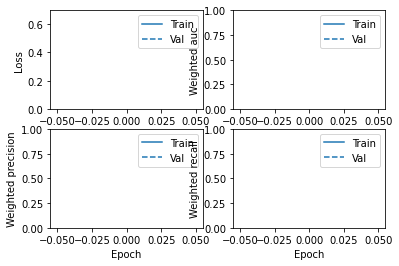

In [55]:
plot_metrics(history_restnet50)

In [ ]:
# cm = cm_calc(resnet50_full_model, test_ds);
cm = cm_calc(resnet50_full_model, resnet50_val_ds);
cm
balanced_acc = balanced_acc_calc(cm)
balanced_acc
plot_cm(cm)

In [ ]:
# Avalia o modelo na validação
score_full_restnet50 = resnet50_full_model.evaluate(processed_val_ds,verbose=1, 
                       #batch_size=batch_size
                       )

print('Valid loss:', score_full_restnet50[0])
print('Valid acc:', score_full_restnet50[1])

### Fine tuning

In [ ]:
# Descongela camadas pré-treinadas
for layer in resnet50_model.layers:
    layer.trainable = True

# Since there are two classes, use a binary cross-entropy loss with from_logits=True since the model provides a linear output.
resnet50_full_model.compile(
    # loss='categorical_crossentropy', 
    #loss='binary_crossentropy',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['acc'],
    optimizer=optimizer
    )
    
resnet50_full_model.summary()

In [ ]:
resnet50_unfreeze_history = resnet50_full_model.fit(
    resnet50_train_ds, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=resnet50_val_ds,
    callbacks=callbacks)

In [ ]:
# Avalia modelo na validação
resnet50_unfreeze_score = model_full_resnet50.evaluate(resnet50_val_ds,verbose=1)
print('Validation loss:', resnet50_unfreeze_score[0])
print('Validation acc:', resnet50_unfreeze_score[1])